In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import sklearn

from sklearn import linear_model
from scipy import stats

from sklearn.linear_model import LinearRegression
from geopy.distance import distance

In [3]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

#     def __init__(self, *args, **kwargs):
#         if not "fit_intercept" in kwargs:
#             kwargs['fit_intercept'] = False
#         super(LinearRegression, self)\
#                 .__init__(*args, **kwargs)
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([
#             np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
#                                                     for i in range(sse.shape[0])
#                     ])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [4]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

In [5]:
earnings = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_taxpayer_income.csv'))

In [6]:
earnings.dropna(inplace=True)

In [8]:
def getYear(series):
    series['year'] = int(series['year'][-4:])
    return series

In [9]:
earnings = earnings.apply(getYear, axis=1)

In [10]:
earnings.head()

,year,area_code,area,population,mean_income,median_income
0,2000,00AA,City of London,10000,109800,40400
1,2001,00AA,City of London,10000,137000,65000
2,2002,00AA,City of London,12000,92900,38300
3,2003,00AA,City of London,11000,78700,37000
4,2004,00AA,City of London,10000,85800,39200


In [11]:
earnings_per_area = earnings.pivot(index='area', columns='year', values='median_income')

In [12]:
earnings_per_area.head()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014,2015,2016,2017,2018
area,,,,,,,,,,,,,,,,,,
Barking and Dagenham,15100,15600,16200,17000,17400,16600,17900,17600,18600,19400,19400,19600,20100,21000,21800,22100,23300,23900
Barnet,18700,19400,18700,19700,20000,19900,21200,20400,22000,24300,24100,24200,25800,26800,27100,27700,28800,28700
Bexley,17200,17300,18300,17800,17700,17700,19400,19600,19800,22100,22600,22300,23100,24400,24400,24500,26100,26900
Brent,16500,16800,16500,16400,16800,16500,17600,18200,18300,19600,19700,20200,20600,21300,22700,23200,24100,24700
Bromley,18500,19500,19100,20100,21400,20900,22400,23000,23200,24900,25800,25100,26900,27200,28100,29800,30400,32000


In [13]:
earnings_per_area.interpolate(inplace=True)

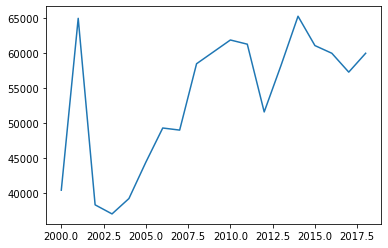

In [14]:
plt.plot(earnings_per_area.loc['City of London'])

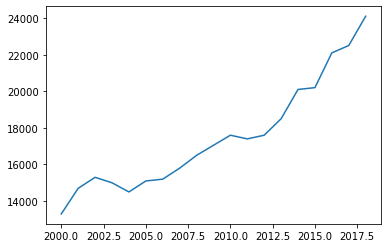

In [15]:
plt.plot(earnings_per_area.loc['Newham'])

Find difference in slopes before and after olympics
===================================================

In [16]:
before_olympics = earnings_per_area.loc[:, :2012]
after_olympics = earnings_per_area.loc[:, 2012:]

In [17]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [18]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [19]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / earnings_per_area.mean(axis=1)

In [20]:
slopes.head()

,before,after,diff
area,,,
Barking and Dagenham,370.391872,728.571429,0.018819
Barnet,507.692308,728.571429,0.009523
Bexley,481.567489,710.714286,0.010820
Brent,335.994194,800.000000,0.023884
Bromley,613.497823,1082.142857,0.019246


Load london borough shape data
==============================

In [21]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

In [22]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.415 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [23]:
london_regions = map_df.NAME

In [24]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [25]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [26]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


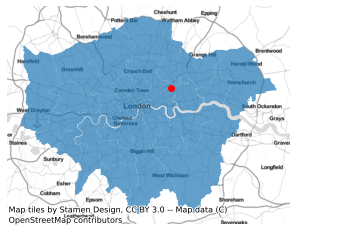

In [27]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Plot merged data
================

In [28]:
merged = map_df.set_index('NAME').join(slopes)

In [29]:
int_series = pd.Series(0.5, index=map_df.NAME)
int_series[['Newham', 'Barking and Dagenham', 'Greenwich', 'Hackney', 'Tower Hamlets', 'Waltham Forest']] = 1.

merged['interesting'] = int_series

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


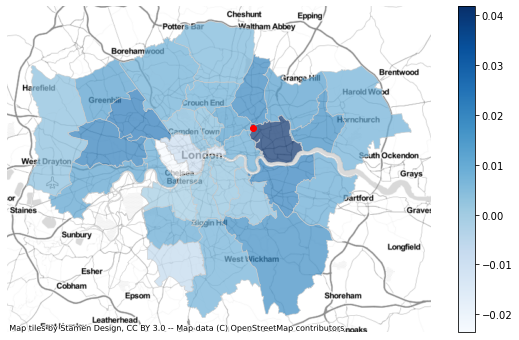

In [84]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='diff', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [85]:
slopes

,before,after,diff
area,,,
Barking and Dagenham,370.391872,728.571429,0.018819
Barnet,507.692308,728.571429,0.009523
Bexley,481.567489,710.714286,0.010820
Brent,335.994194,800.000000,0.023884
Bromley,613.497823,1082.142857,0.019246
Camden,951.814224,1103.571429,0.005515
City of London,1302.031930,639.285714,-0.012454
Croydon,521.480406,707.142857,0.008578
Ealing,401.306241,882.142857,0.022806


In [31]:
merged['before'] = merged['before'] / earnings_per_area.mean(axis=1)

In [32]:
merged['before']['City of London'] = 0

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
merged['before']

NAME
Kingston upon Thames           NaN
Croydon                   0.024093
Bromley                   0.025195
Hounslow                  0.025410
Ealing                    0.019034
Havering                  0.028108
Hillingdon                0.026758
Harrow                    0.020122
Brent                     0.017295
Barnet                    0.021889
Lambeth                   0.033652
Southwark                 0.036829
Lewisham                  0.033137
Greenwich                 0.022764
Bexley                    0.022739
Enfield                   0.024739
Waltham Forest            0.022655
Redbridge                 0.024688
Sutton                    0.031318
Richmond upon Thames           NaN
Merton                    0.024141
Wandsworth                0.032992
Hammersmith and Fulham    0.028243
Kensington and Chelsea    0.038414
Westminster               0.038806
Camden                    0.034590
Tower Hamlets             0.033263
Islington                 0.032949
Hackney        

In [34]:
dists = pd.read_csv('region_distances.csv').set_index('NAME')

In [35]:
mdists = map_df.set_index('NAME').join(dists)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


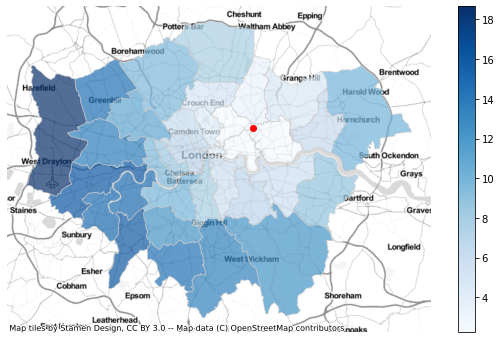

In [36]:
fig, ax = plt.subplots(1, figsize=(10, 6))
mdists.plot(column='Distance', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


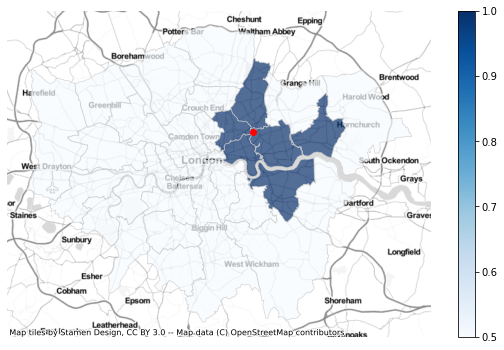

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='interesting', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

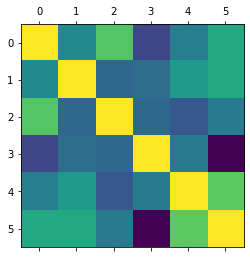

In [38]:
plt.matshow(mdists.join(slopes).corr())

In [39]:
mdists.join(slopes).corr()

,HECTARES,NONLD_AREA,Distance,before,after,diff
HECTARES,1.000000,0.032552,0.509195,-0.448645,-0.054453,0.269038
NONLD_AREA,0.032552,1.000000,-0.228227,-0.182622,0.150869,0.280429
Distance,0.509195,-0.228227,1.000000,-0.225531,-0.337961,-0.079001
before,-0.448645,-0.182622,-0.225531,1.000000,-0.086022,-0.841967
after,-0.054453,0.150869,-0.337961,-0.086022,1.000000,0.533997
diff,0.269038,0.280429,-0.079001,-0.841967,0.533997,1.000000


In [40]:
profiles = pd.read_csv('london-borough-profiles.csv', encoding='ISO-8859-2')

In [41]:
profiles.set_index('Area_name').loc['Newham']

Code                                                            E09000025
Inner/_Outer_London                                          Inner London
GLA_Population_Estimate_2017                                       342900
GLA_Household_Estimate_2017                                        119172
Inland_Area_(Hectares)                                              3,620
                                                                 ...     
Political_control_in_council                                          Lab
Proportion_of_seats_won_by_Conservatives_in_2014_election               0
Proportion_of_seats_won_by_Labour_in_2014_election                    100
Proportion_of_seats_won_by_Lib_Dems_in_2014_election                    0
Turnout_at_2014_local_elections                                      40.5
Name: Newham, Length: 83, dtype: object

In [42]:
profiles.set_index('Area_name').join(slopes).corr().loc['diff']

GLA_Population_Estimate_2017                          0.006870
Average_Age,_2017                                    -0.466123
Proportion_of_population_aged_0-15,_2015              0.602706
Proportion_of_population_of_working-age,_2015        -0.236992
Proportion_of_population_aged_65_and_over,_2015      -0.236456
New_migrant_(NINo)_rates,_(2015/16)                   0.047012
Employment_rate_(%)_(2015)                           -0.031742
%_of_employment_that_is_in_public_sector_(2014)       0.379076
Jobs_Density,_2015                                   -0.355299
Number_of_active_businesses,_2015                    -0.000064
Two-year_business_survival_rates_(started_in_2013)    0.183995
Number_of_cars,_(2011_Census)                         0.005299
Number_of_cars_per_household,_(2011_Census)           0.187055
%_children_living_in_out-of-work_households_(2015)    0.159092
Life_satisfaction_score_2011-14_(out_of_10)          -0.100816
Worthwhileness_score_2011-14_(out_of_10)             -0

In [43]:
profiles.set_index('Area_name').join(dists).corr().loc['Distance']

GLA_Population_Estimate_2017                          0.035107
Average_Age,_2017                                     0.416243
Proportion_of_population_aged_0-15,_2015              0.142736
Proportion_of_population_of_working-age,_2015        -0.535341
Proportion_of_population_aged_65_and_over,_2015       0.549599
New_migrant_(NINo)_rates,_(2015/16)                  -0.468055
Employment_rate_(%)_(2015)                            0.530636
%_of_employment_that_is_in_public_sector_(2014)      -0.316548
Jobs_Density,_2015                                   -0.201112
Number_of_active_businesses,_2015                    -0.197319
Two-year_business_survival_rates_(started_in_2013)    0.566712
Number_of_cars,_(2011_Census)                         0.570414
Number_of_cars_per_household,_(2011_Census)           0.715940
%_children_living_in_out-of-work_households_(2015)   -0.610379
Life_satisfaction_score_2011-14_(out_of_10)           0.480959
Worthwhileness_score_2011-14_(out_of_10)              0

In [44]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [45]:
fa = FactorAnalyzer()

In [46]:
all_things = profiles.set_index('Area_name').join(dists).join(slopes)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = all_things.select_dtypes(include=numerics)
newdf.dropna(inplace=True)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
x_test = newdf.drop(['before', 'after', 'diff', 'Proportion_of_population_aged_0-15,_2015', 'Proportion_of_population_of_working-age,_2015', 'Proportion_of_population_aged_65_and_over,_2015'], axis=1)

In [48]:
reg_diff = LinearRegression()

reg_diff.fit(x_test, newdf['diff'])

LinearRegression()

In [49]:
reg_diff.coef_

array([-6.46164281e-08, -8.35674870e-04,  3.83279502e-04, -1.15240566e-05,
        2.53419063e-04, -1.26260417e-03, -2.90309958e-07,  1.46261458e-04,
        4.31229740e-07, -2.52081891e-03,  3.49082277e-04,  5.40958453e-03,
       -3.90551146e-03, -3.69475914e-02,  1.59471576e-02,  1.51858252e-03,
       -5.53379572e-04])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

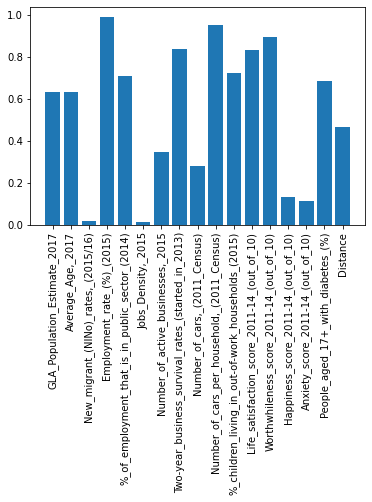

In [50]:
plt.bar(x_test.columns, reg_diff.p[0])
plt.xticks(rotation=90)

In [51]:
reg_second = LinearRegression()
reg_second.fit(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']], newdf['diff'])

LinearRegression()

In [52]:
sklearn.metrics.r2_score(newdf['diff'], reg_second.predict(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']]))

0.24004989241256758

In [53]:
reg_diff.p[reg_diff.p < 0.05]

array([0.01502626, 0.01048471])

In [54]:
y_preds = reg_diff.predict(x_test)

In [55]:
sklearn.metrics.r2_score(newdf['diff'], y_preds)

0.8112165208603556

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

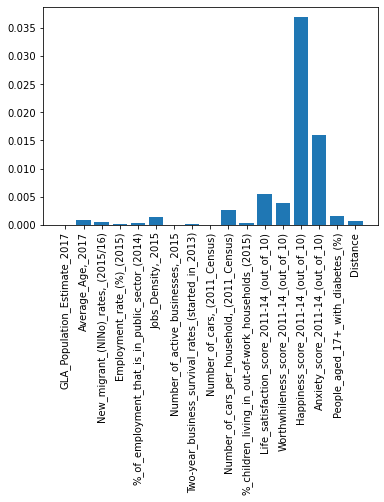

In [56]:
plt.bar(x_test.columns, abs(reg_diff.coef_))
plt.xticks(rotation=90)

In [57]:
fa.fit(newdf)

FactorAnalyzer(rotation_kwargs={})

[Text(0, 0, 'GLA_Population_Estimate_2017'),
 Text(0, 0, 'Average_Age,_2017'),
 Text(0, 0, 'Proportion_of_population_aged_0-15,_2015'),
 Text(0, 0, 'Proportion_of_population_of_working-age,_2015'),
 Text(0, 0, 'Proportion_of_population_aged_65_and_over,_2015'),
 Text(0, 0, 'New_migrant_(NINo)_rates,_(2015/16)'),
 Text(0, 0, 'Employment_rate_(%)_(2015)'),
 Text(0, 0, '%_of_employment_that_is_in_public_sector_(2014)'),
 Text(0, 0, 'Jobs_Density,_2015'),
 Text(0, 0, 'Number_of_active_businesses,_2015'),
 Text(0, 0, 'Two-year_business_survival_rates_(started_in_2013)'),
 Text(0, 0, 'Number_of_cars,_(2011_Census)'),
 Text(0, 0, 'Number_of_cars_per_household,_(2011_Census)'),
 Text(0, 0, '%_children_living_in_out-of-work_households_(2015)'),
 Text(0, 0, 'Life_satisfaction_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Worthwhileness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Happiness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Anxiety_score_2011-14_(out_of_10)'),
 Text(0, 0, 'People_aged_17+_with_d

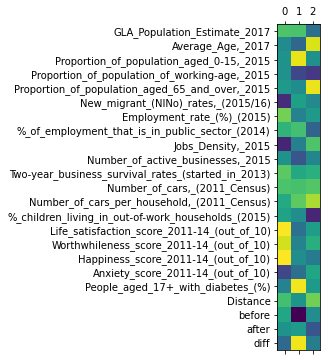

In [58]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.matshow(fa.loadings_)
ax.set_yticks(range(len(newdf.columns)))
ax.set_yticklabels(newdf.columns)

In [59]:
fa.loadings_

array([[ 0.43023377,  0.405595  , -0.30911672],
       [-0.07134238, -0.37286648,  0.88477346],
       [-0.00946026,  0.92901252, -0.02758774],
       [-0.02060332, -0.61887097, -0.72227252],
       [ 0.0419426 , -0.06934191,  0.93898142],
       [-0.80666079,  0.10491472, -0.09503146],
       [ 0.5715975 , -0.1496217 ,  0.0522532 ],
       [ 0.27794721,  0.38119248, -0.40832381],
       [-0.85427841, -0.15474909,  0.43496513],
       [-0.00872093, -0.52138732, -0.12016217],
       [ 0.47829936,  0.18051991,  0.24603391],
       [ 0.41356111,  0.39846097,  0.44722441],
       [ 0.19713853,  0.48583557,  0.74118081],
       [ 0.12346875, -0.05500729, -0.84571407],
       [ 0.9910694 , -0.29599043,  0.08056617],
       [ 0.86125971, -0.1451552 ,  0.22735799],
       [ 1.00049792, -0.05100106, -0.22167893],
       [-0.63026769, -0.30088481,  0.15306178],
       [-0.14846327,  0.96101817,  0.04511342],
       [ 0.37938802,  0.00665893,  0.55851334],
       [ 0.17075947, -1.06740396, -0.050

In [60]:
calculate_kmo(newdf)

(array([0.5372767 , 0.25339385, 0.31380574, 0.31394771, 0.24630796,
        0.53116962, 0.17296413, 0.30780862, 0.65907703, 0.18866794,
        0.23358331, 0.72248945, 0.84956707, 0.34824715, 0.2652823 ,
        0.290056  , 0.36788921, 0.37060863, 0.3228446 , 0.4435803 ,
        0.31193949, 0.12217677, 0.22229965]),
 0.33139686796178286)

In [61]:
calculate_bartlett_sphericity(newdf)

(1189.6648992215435, 1.6924586553917933e-121)

In [62]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(newdf, 25)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([8.90010345e+00, 5.22158894e+00, 2.68435843e+00, 1.30727841e+00,
       1.24914085e+00, 9.12713627e-01, 7.10268497e-01, 5.40557619e-01,
       4.17156680e-01, 3.10553478e-01, 2.24944242e-01, 1.59290899e-01,
       1.10304789e-01, 8.48343130e-02, 7.38674899e-02, 3.35746133e-02,
       2.26589390e-02, 1.96921081e-02, 7.77009328e-03, 4.72433768e-03,
       3.21921381e-03, 1.39547368e-03, 3.49852928e-06])

Wealth Gap
==========

In [63]:
olympic_boroughs = ['Newham', 'Barking and Dagenham', 'Greenwich', 'Hackney', 'Tower Hamlets', 'Waltham Forest']

In [64]:
def split_olympics(series):
    
    return pd.Series({
        'olympic_avg': series[olympic_boroughs].median(),
        'nonolympic_avg': series[~series.index.isin(olympic_boroughs)].median(),
        'total_avg': series.median()
    })

In [65]:
earnings.head()

,year,area_code,area,population,mean_income,median_income
0,2000,00AA,City of London,10000,109800,40400
1,2001,00AA,City of London,10000,137000,65000
2,2002,00AA,City of London,12000,92900,38300
3,2003,00AA,City of London,11000,78700,37000
4,2004,00AA,City of London,10000,85800,39200


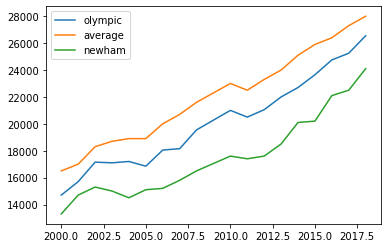

In [83]:
plt.plot(earnings[earnings.area.isin(olympic_boroughs)].pivot_table(index='year', values='median_income', aggfunc=np.median), label='olympic')
plt.plot(earnings[earnings.area.isin(london_regions)].pivot_table(index='year', values='median_income', aggfunc=np.median), label='average')
plt.plot(earnings[earnings.area == 'Newham'].set_index('year').median_income, label='newham')
plt.legend()

In [68]:
olympic_avg = earnings[earnings.area.isin(olympic_boroughs)].pivot_table(index='year', values='median_income', aggfunc=np.median)
overall_avg = earnings[earnings.area.isin(london_regions)].pivot_table(index='year', values='median_income', aggfunc=np.median)

(0.0, 2620.0)

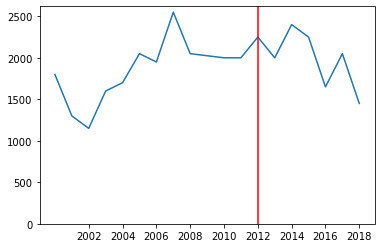

In [71]:
f, ax = plt.subplots(1)
ax.plot(overall_avg - olympic_avg)
plt.xticks(range(2002, 2019, 2))
ax.axvline(2012, color='red')
ax.set_ylim(bottom=0)

In [72]:
income_info = earnings_per_area.apply(split_olympics)

In [73]:
income_info

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014,2015,2016,2017,2018
olympic_avg,14700.0,15700.0,17150.0,17100.0,17200.0,16850.0,18050.0,18150.0,19550.0,21000.0,20500.0,21050.0,22000.0,22700.0,23650.0,24750.0,25250.0,26550.0
nonolympic_avg,16100.0,16900.0,17600.0,18100.0,18800.0,18400.0,20000.0,20400.0,20900.0,22300.0,22200.0,22700.0,23300.0,24400.0,25300.0,25900.0,26100.0,27300.0
total_avg,15700.0,16600.0,17600.0,17900.0,18200.0,18300.0,19400.0,19600.0,20800.0,22100.0,22000.0,22700.0,23200.0,24300.0,25100.0,25800.0,26100.0,27300.0


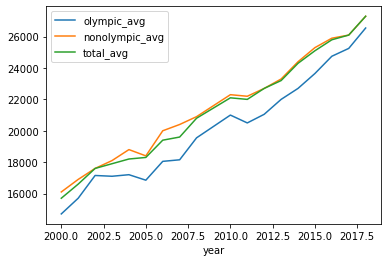

In [74]:
income_info.transpose().plot.line()

In [134]:
income_info[2009]

olympic_avg       90.58125
nonolympic_avg    92.24750
total_avg         92.24750
Name: 2009, dtype: float64

In [135]:
income_info[2015]

olympic_avg       94.50125
nonolympic_avg    95.81250
total_avg         95.81250
Name: 2015, dtype: float64

In [137]:
income_info[2009]['total_avg'] - income_info[2009]['olympic_avg']

1.6662500000000051

In [138]:
income_info[2015]['total_avg'] - income_info[2015]['olympic_avg']

1.311249999999987

Population
==========

In [75]:
earnings.head()

,year,area_code,area,population,mean_income,median_income
0,2000,00AA,City of London,10000,109800,40400
1,2001,00AA,City of London,10000,137000,65000
2,2002,00AA,City of London,12000,92900,38300
3,2003,00AA,City of London,11000,78700,37000
4,2004,00AA,City of London,10000,85800,39200


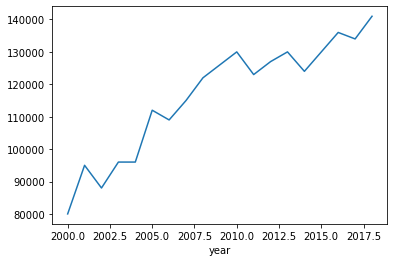

In [82]:
earnings[earnings.area == 'Newham'].set_index('year').population.plot.line()

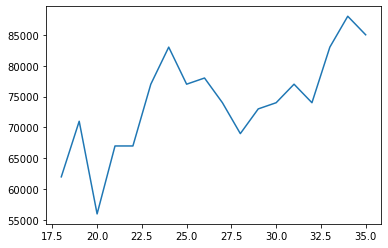

In [78]:
earnings[earnings.area == 'Barking and Dagenham'].population.plot.line()